In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian
import scipy
import cv2
from scipy import ndimage
import Image_preperation as prep
import FileManager as fm

def calc_internal(p1,p2):
    if (np.array_equal(p1,p2)):
        return 100
    return np.sum( (p2 - p1)**2 )

def calc_internal_mean(p1,p2, mean):
    
    dist = scipy.spatial.distance.euclidean(p1,p2)
    diff = (mean - dist)**2
    return  diff

def calc_mean(points):
    
    size = len(points)
    p1 = points[-1]
    p2 = points[0]
    mean_sum = scipy.spatial.distance.euclidean(p1,p2)
    
    for i in range(size-1):
        p1 = points[i]
        p2 = points[i+1]
        mean_sum += scipy.spatial.distance.euclidean(p1,p2)
        
    return mean_sum / size

# def calc_external_img(img):
    
#     img = rgb2gray(img)
    
#     sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
#     abs_sobel64f = np.absolute(sobelx64f)
#     sobelx = np.uint8(abs_sobel64f)
    
#     sobely64f = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
#     abs_sobel64f = np.absolute(sobely64f)
#     sobely = np.uint8(abs_sobel64f)

#     return -(sobelx + sobely)

def calc_external_img2(img): 

    img = np.array(img, dtype=np.uint16)
    kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    Gx = cv2.filter2D(img,-1,kx)
    
    ky = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    Gy = cv2.filter2D(img,-1,ky)
    
    G = np.sqrt(Gx**2 + Gy**2)
    
    return -G
    
def calc_external(p, external_img):
    
    p = p.astype(int)
    
    return external_img[p[0],p[1]]
    
def calc_energy(p1, p2, external_img, alpha):
     
    internal = calc_internal(p1,p2)
    external = calc_external(p1, external_img)
    
    return internal + alpha * external


def calc_internal2(p1,p2,p3, alpha, beta):

    distance = alpha * (p3 - p2)**2
    curvature = beta * (p3 - 2*p2 + p1)**2 
    return np.sum( distance + curvature)


def calc_energy2(p1, p2, p3, external_img, alpha, beta, gamma):
     
    internal = calc_internal2(p1,p2, p3,alpha, beta)
    external = calc_external(p3, external_img)
    
    return internal + gamma * external

def calc_energy3(p1, p2, mean, external_img, alpha):
     
    internal = calc_internal_mean(p1,p2, mean)
    external = calc_external(p2, external_img)
    
    return internal + alpha * external



def get_point_state(point, number, pixel_width):
    
    n=0
    for i in range(-pixel_width , pixel_width+1):
        for j in range(-pixel_width , pixel_width+1):          
            if n == number:
                return np.array([point[0]+i , point[1]+j])
            n +=1
    return

def unpack(number, back_pointers, points, pixel_width):
    
    size = len(points)
    new_points = np.empty((size,2))
    
    new_points[-1] = get_point_state(points[-1],number, pixel_width)
    pointer = back_pointers[-1,number]
    
    for i in range(size-2, -1, -1):
        
        new_points[i] = get_point_state(points[i],pointer, pixel_width)
        pointer = back_pointers[i,pointer]
        
    return new_points

#https://courses.engr.illinois.edu/cs447/fa2017/Slides/Lecture07.pdf
def viterbi(points, img, pixel_width, alpha):
    size = len(points)
    num_states = (2*pixel_width +1)**2
    
    center = int((num_states-1)/2)
    
    trellis = np.empty((size, num_states), dtype=np.float16)
    back_pointers = np.empty((size, num_states), dtype=int)
    external_img = calc_external_img2(img)
    
    #init
    trellis[0,:] = np.zeros((num_states))
    back_pointers[0,:] = np.full((num_states),center)
    
    mean = calc_mean(points)
    
    #recursion
    for i in range(1, size):
        for t in range(num_states):
            trellis[i,t] = np.inf
            for d in range(num_states):
                p1 = get_point_state(points[i-1], d, pixel_width)
                p2 = get_point_state(points[i],t, pixel_width)
                energy_trans = calc_energy(p1, p2, external_img, alpha)
#                 energy_trans = calc_energy3(p1, p2, mean, external_img, alpha)

                tmp = trellis[i-1,d] + energy_trans

                if(tmp < trellis[i,t]):
                    trellis[i,t] = tmp
                    back_pointers[i,t] = d
            
    #find best
    t_best, vit_min = 0, np.inf
    for t in range(num_states):
        if(trellis[size-1, t] < vit_min):
            t_best = t
            vit_min = trellis[size-1, t]

    return unpack(t_best, back_pointers, points, pixel_width)

def viterbi2(points, img, pixel_width, alpha, beta, gamma):
    size = len(points)
    num_states = (2*pixel_width +1)**2
    
    center = int((num_states-1)/2)
    
    trellis = np.empty((size, num_states), dtype=np.float16)
    back_pointers = np.empty((size, num_states), dtype=int)
    external_img = calc_external_img2(img)
    
    #init
    trellis[0:2,:] = np.zeros((2,num_states))
    back_pointers[0:2,:] = np.full((2,num_states),center)
    
    #recursion
    for i in range(2, size):
        for t in range(num_states):
            trellis[i,t] = np.inf
            for d1 in range(num_states):
                for d2 in range(num_states):
                    p1 = get_point_state(points[i-2], d1, pixel_width)
                    p2 = get_point_state(points[i-1], d2, pixel_width)
                    p3 = get_point_state(points[i],t, pixel_width)
                    energy_trans = calc_energy2(p1, p2,p3, external_img, alpha, beta, gamma)

                    tmp = trellis[i-1,d2] + energy_trans

                    if(tmp < trellis[i,t]):
                        trellis[i,t] = tmp
                        back_pointers[i,t] = d2
            
    #find best
    t_best, vit_min = 0, np.inf
    for t in range(num_states):
        if(trellis[size-1, t] < vit_min):
            t_best = t
            vit_min = trellis[size-1, t]

    return unpack(t_best, back_pointers, points, pixel_width)

def active_contour(points, img, max_loop, pixel_width, alpha):
    
    old_points = points
    for i in range(max_loop):
        new_points = viterbi(old_points, img, pixel_width, alpha)
        if np.array_equal(new_points, old_points):
            print(i)
            break
            
        #old_points = new_points
        head, tail = np.split(new_points, [6])
        old_points = np.append(tail, head).reshape(new_points.shape)
        
    return new_points


def active_contour2(points, img, max_loop, pixel_width, alpha, beta, gamma):
    
    old_points = points
    for i in range(max_loop):
        new_points = viterbi(old_points, img, pixel_width, alpha, beta, gamma)
        if np.array_equal(new_points, old_points):
            print(i)
            break
            
        #old_points = new_points
        head, tail = np.split(new_points, [1])
        old_points = np.append(tail, head).reshape(new_points.shape)
        
    return new_points


def resolution_downscale(img, resize): 
    x, y = img.shape
    xn = int(x/resize)
    yn = int(y/resize)

    return cv2.resize(img, (yn ,xn)) 

def previous_test():
    dir_radiographs = "_Data\Radiographs\*.tif"
    radiographs = fm.load_files(dir_radiographs)
    radiograph = radiographs[0]
    init = np.load("initial_position.npy")
    
    down_sample = 5
    tooth = init[0,4,:,:]/0.3
    #tooth = tooth/down_sample

    radiograph_pre = pre_processing(radiograph)
    img = resolution_downscale(radiograph_pre,down_sample)

    fig, ax = plt.subplots(figsize=(15, 15))
    plt.imshow(radiograph)
    plt.plot(tooth[:,0], tooth[:,1], 'ro', markersize=1)
    plt.show()

def test_module():
    piece = fm.load_img_piece()
    tooth = fm.load_tooth_of_piece(0)
    ext = calc_external_img2(piece) 
    fm.show_with_points(ext, tooth)
    
    img, stooth = fm.resolution_scale(piece, tooth, 1/6)
    ext = calc_external_img2(img) 
    fm.show_with_points(ext, stooth)
    
    new_tooth = active_contour(stooth, img, 1, 3, 1)
    fm.show_with_points(ext, new_tooth)

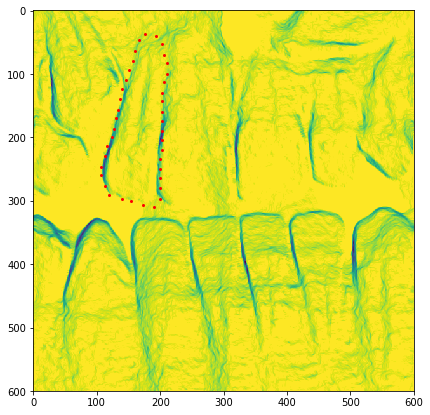

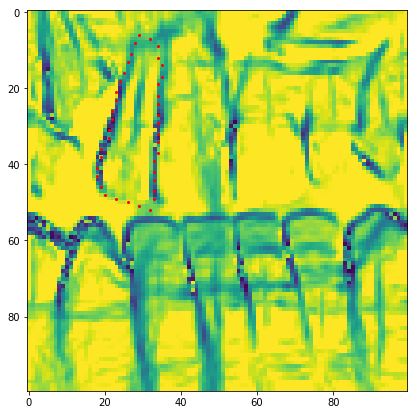

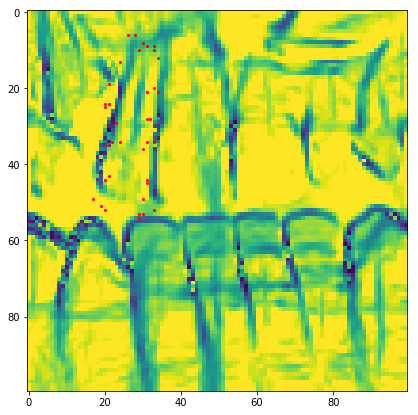

In [6]:
if __name__ == "__main__":

    test_module()